# Neural Style Transfer

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt

import copy
from scipy import ndimage

## Style transfer

The Neural Style Transfer is an algorithm that takes as input a content-image and a style-image and returns the content of the content-image as if it was ‘painted’ using the artistic style of the style-image.

For a style image I will use "The Jungle", 1942-43. <it>The Jungle</it> is a painting from the Cuban artist Wifredo Lam.

In [2]:
PATH = Path("/home/chris/catchup/DL/HW4/")

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(1014, 1280, 3)

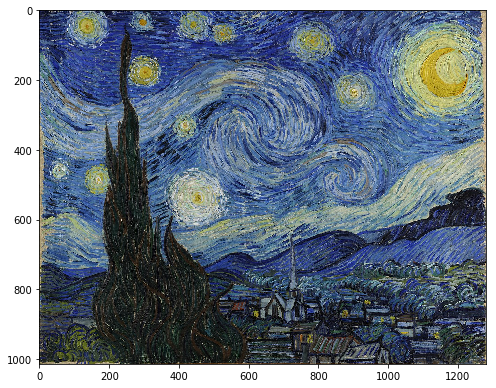

In [4]:
path = PATH/"starry.jpg"
im1 = read_image(path)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im1)
im1.shape

(1564, 2346, 3)

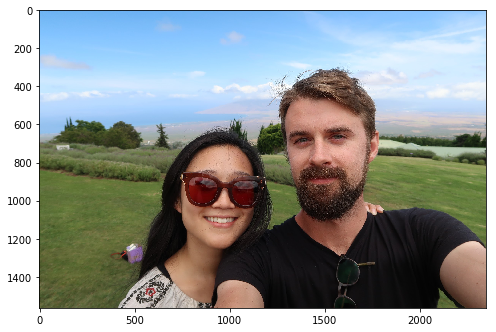

In [5]:
path2 = PATH/"us.jpg"
im2 = read_image(path2)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im2)
im2.shape

## Preprocessing
We need style and content images of the same size.

In [6]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

(300, 300, 3)

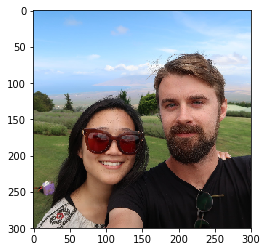

In [7]:
im2 = center_crop(im2)
im2 = cv2.resize(im2, (300, 300))
plt.imshow(im2)
im2.shape

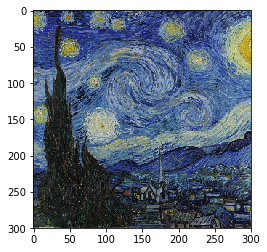

In [8]:
im1 = center_crop(im1)
im1 = cv2.resize(im1, (300, 300))
im1.shape
plt.imshow(im1)

In [9]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [10]:
im_style = transform_images(im1/255)
im_content = transform_images(im2/255)

In [11]:
im_style.shape

torch.Size([1, 3, 300, 300])

## Prepare vgg19

In [12]:
# get vgg16 model
vgg = models.vgg19(True).cuda().eval()

In [13]:
list(vgg.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace)
   (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (17): ReLU(inplace)
   (18): MaxPool2d(kernel_size=2, s

In [14]:
layers = list(vgg.children())[0]

#m_vgg = nn.Sequential(*layers[:19]) # after conv4_1
m_vgg = nn.Sequential(*layers[:10]) # after conv3_1
# freezing parameters
for param in m_vgg.parameters():
    param.requires_grad = False

In [15]:
# indices for all Relus
block_relu = [i for i,o in enumerate(layers)
              if isinstance(o, nn.ReLU)]
block_relu

[1, 3, 6, 8, 11, 13, 15, 17, 20, 22, 24, 26, 29, 31, 33, 35]

In [16]:
# indices for all MaxPool2d
[i for i,o in enumerate(layers) if isinstance(o, nn.MaxPool2d)]

[4, 9, 18, 27, 36]

## Content optimization

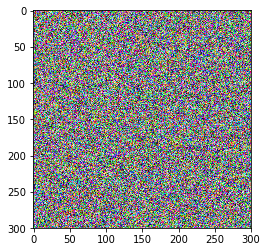

In [17]:
# start with a random image
opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
plt.imshow(opt_img)

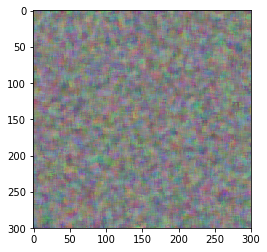

In [18]:
opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
opt_img = opt_img 
plt.imshow(opt_img)

In [19]:
im_opt = transform_images(opt_img)
im_opt.shape

torch.Size([1, 3, 300, 300])

In [20]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
im_opt.requires_grad=True

In [21]:
# Making the image pixes the parameters of the model
optimizer = optim.LBFGS([im_opt], lr=0.01)

In [22]:
# the target here is the output of the content image
# after vgg19
targ_v = m_vgg(im_content).detach()
targ_v.shape

torch.Size([1, 128, 75, 75])

In [23]:
F.mse_loss(m_vgg(im_opt), targ_v).item()

1.7599371671676636

In [24]:
# for optim.LBFGS we have to define a closure function
def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            loss = F.mse_loss(m_vgg(im_opt), targ_v)
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            print(i, (F.mse_loss(m_vgg(im_opt), targ_v)).item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [25]:
im_opt = train_image(optimizer, targ_v, im_opt, 1000)

1 1.2193442583084106
51 0.1664053499698639
101 0.11606249958276749
151 0.10929489880800247
201 0.09653117507696152
251 0.07800191640853882
301 0.07662290334701538
351 0.07375035434961319
401 0.07268255949020386
451 0.056566525250673294
501 0.05396704003214836
551 0.051721204072237015
601 0.05012211203575134
651 0.04866812750697136
701 0.0442361943423748
751 0.04382826015353203
801 0.04288972541689873
851 0.0427081324160099
901 0.03889824077486992
951 0.03623763471841812


In [26]:
x = im_opt.cpu().detach().numpy()

In [27]:
x = x[0]
x.shape

(3, 300, 300)

In [28]:
x = np.rollaxis(x,0,3)

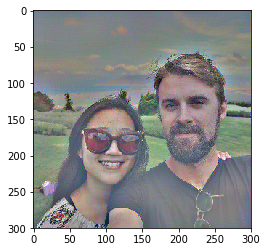

In [29]:
plt.imshow(x)

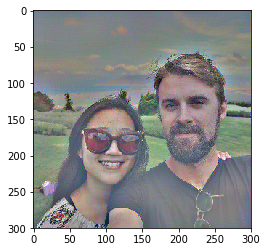

In [30]:
plt.imshow(x) # layer 20

## Style Optimization

For style optimization we will be using conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1. These correspond to indices: `[0, 5, 10, 19, 28]`.

In [31]:
def get_input(lr=0.01, alpha=0.1):
    opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img = (1-alpha)*opt_img + alpha*im2/255
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.LBFGS([im_opt], lr=0.01)
    return im_opt, optimizer
im_opt, optimizer = get_input()

In [32]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        #self.select = ['0', '5', '10', '19', '28'] 
        self.select = ['0', '5', '10', '19'] 
        self.vgg = models.vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # unrolling feature maps

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

opt_img, optimizer = get_input(lr=0.1, alpha=0.0)
vgg = VGGNet().cuda().eval()

im_style_f = vgg(im_style)

[o.shape for o in im_style_f]

# note that gram_matrix(f) is location independent
targ_g = [gram_matrix(f).detach() for f in im_style_f]
[o.shape for o in targ_g]

def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%100 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            print(i, loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

im_opt, optimizer = get_input(lr=0.1, alpha=0.0)

im_opt = train_style(optimizer, targ_g, im_opt, 1000)

x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

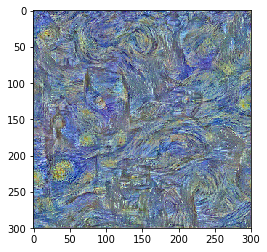

In [42]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

## Style transfer

In [43]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, alpha=1.5):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

im_style_f = vgg(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

im_content_f = vgg(im_content)
targ_v = im_content_f[2].detach()
targ_v.shape

im_opt, optimizer = get_input(lr=0.5)

im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=5000)

x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

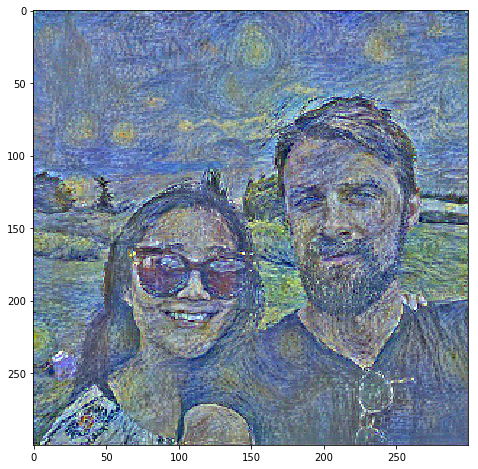

In [49]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)

# References
The idea for the model in this notebook is based on notebook is based on this [pytorch tutorial](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/neural_style_transfer/main.py). I also looked at these other notebooks and papers:

* This [fast.ai notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb) 
* This [paper](https://arxiv.org/pdf/1508.06576.pdf).
* This [block post](https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199)

## Experimentation: Change the layers

using only 2 and 5, then 

1 0.21311955153942108
101 0.00014184867904987186
201 0.00012100323510821909
301 0.00012097640137653798
401 0.00012096217687940225
501 0.00012095028068870306
601 0.00012093943951185793
701 0.00012092920223949477
801 0.00012091940152458847
901 0.0001209099282277748


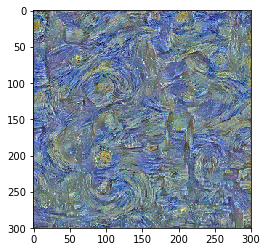

In [61]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        #self.select = ['0', '5', '10', '19', '28'] 
        self.select = ['2', '5', '10', '21', '25', '34'] 
        self.vgg = models.vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # unrolling feature maps

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

opt_img, optimizer = get_input(lr=0.1, alpha=0.0)
vgg = VGGNet().cuda().eval()

im_style_f = vgg(im_style)

[o.shape for o in im_style_f]

# note that gram_matrix(f) is location independent
targ_g = [gram_matrix(f).detach() for f in im_style_f]
[o.shape for o in targ_g]

def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%100 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            print(i, loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

im_opt, optimizer = get_input(lr=0.1, alpha=0.0)

im_opt = train_style(optimizer, targ_g, im_opt, 1000)

x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

# transfer, different alphas

27.233440399169922
0.8993009328842163
0.7185354828834534
0.6532522439956665
0.6339240074157715
0.6265614032745361
0.6231900453567505
0.6179156303405762
0.6136001944541931
0.6122173070907593
0.6116827726364136
0.6094295382499695
0.6061642169952393
0.6049094200134277
0.6046111583709717
0.6031184196472168
0.6016988754272461
0.6014682650566101
0.6013944149017334
0.6005207896232605


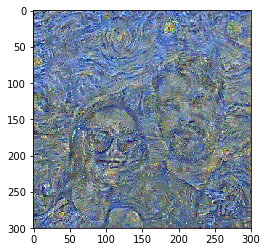

In [56]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, alpha=0.5):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

im_style_f = vgg(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

im_content_f = vgg(im_content)
targ_v = im_content_f[2].detach()
targ_v.shape

im_opt, optimizer = get_input(lr=0.5)

im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=5000)

x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

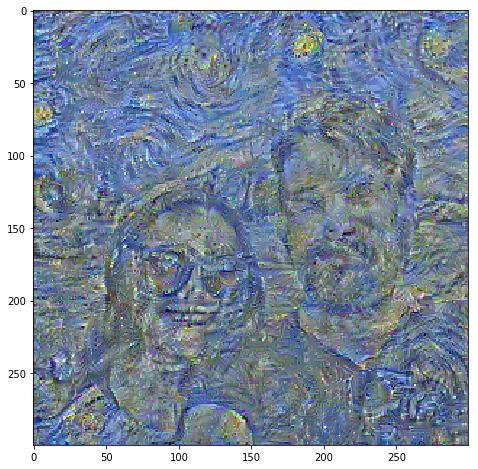

In [57]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)

Wow, this is definitely more "stylistic"!

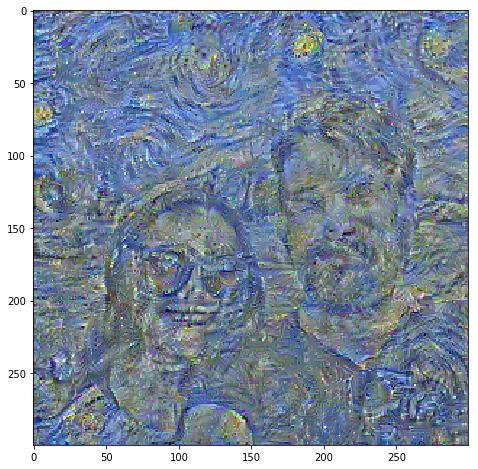

In [58]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)
plt.savefig('us-more-style.png')

27.505422592163086
0.880077600479126
0.7105526924133301
0.6717873811721802
0.6548364162445068
0.6457675099372864
0.6386793255805969
0.6342599391937256
0.6312240362167358
0.62949138879776
0.6290472149848938
0.6254897713661194
0.6196452379226685
0.61738520860672
0.6169188618659973
0.6144331097602844
0.6116822361946106
0.6110579967498779
0.6102668046951294
0.6085140705108643


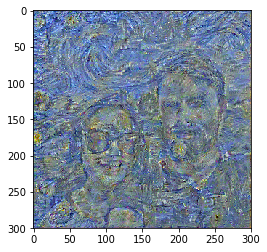

In [59]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, alpha=0.8):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

im_style_f = vgg(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

im_content_f = vgg(im_content)
targ_v = im_content_f[2].detach()
targ_v.shape

im_opt, optimizer = get_input(lr=0.5)

im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=5000)

x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

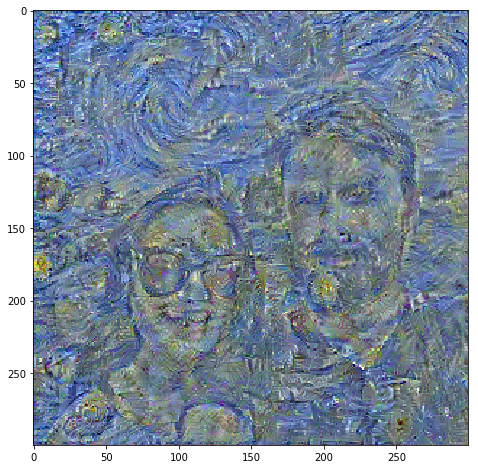

In [60]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)
plt.savefig('us-more-alpha08.png')

108.69691467285156
1.557896614074707
1.3243415355682373
1.2864049673080444
1.2750133275985718
1.265383243560791
1.2578184604644775
1.2542177438735962
1.2518770694732666
1.2367805242538452
1.223268985748291
1.2215007543563843
1.2173937559127808
1.2090880870819092
1.2073845863342285
1.2067742347717285
1.2023006677627563
1.1988469362258911
1.198398470878601
1.1975919008255005


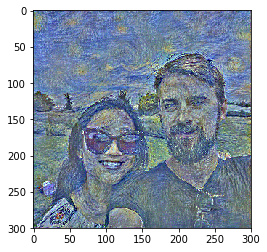

In [62]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, alpha=1.2):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

im_style_f = vgg(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]

im_content_f = vgg(im_content)
targ_v = im_content_f[2].detach()
targ_v.shape

im_opt, optimizer = get_input(lr=0.5)

im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=5000)

x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

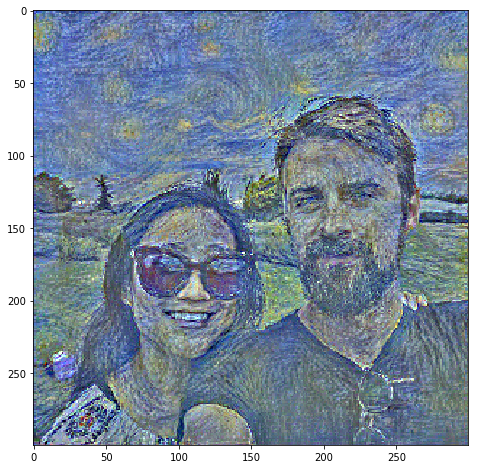

In [63]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(x)
plt.savefig('us-more-alpha12.png')

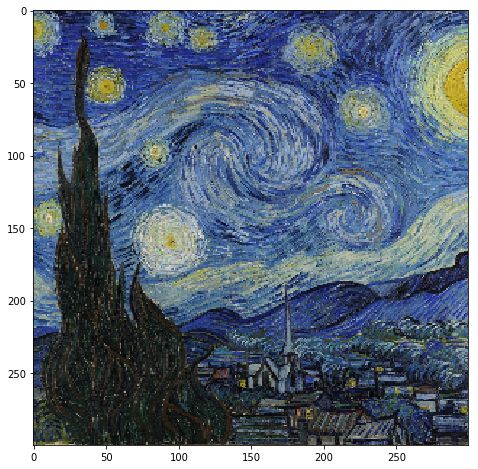

In [65]:
fig2 = plt.figure(figsize = (8,8))
plt.imshow(im1)


In [66]:
# not bad